In [1]:
import numpy as np
from scipy.io import loadmat
import copy
from scipy import optimize
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
#import matrix

mat = loadmat("ex3data1.mat")
X = mat["X"]
y = mat["y"]

In [3]:
def rearangeList(initial, final ,length):
    finallist = []
    answerSize = 0
    
    while answerSize < length:
        r = random.randint(initial,final-1)
        if r not in finallist:
            answerSize += 1
            finallist.append(r)
    return finallist

In [4]:
# Spliting X into 3 samples with same proportion of classes

def sample(X,y, per_training, per_aval, per_test):
    l = len(X)
    # number of classes
    classes = max(y)[0]
    size_class = int(l/classes)
    size_train = int(size_class*per_training)
    size_aval = int(size_class*per_aval)
    size_test = int(size_class*per_test)
    
    # the sample should be proportional to size of each class. In that case, each class has equal size
    # for each class take a sample 
    
    for i in range(classes):
        
        if i ==0:
            rearange = rearangeList(i*size_class,(i+1)*size_class, size_class)
            X_train = X[rearange[: size_train],:]
            y_train = y[rearange[: size_train]]
            X_aval = X[rearange[size_train: size_train+size_aval],:]
            y_aval = y[rearange[size_train: size_train+size_aval]]
            X_test = X[rearange[size_train+size_aval: size_train+size_aval+ size_test],:]
            y_test = y[rearange[size_train+size_aval: size_train+size_aval+ size_test]]
        else: 
            rearange = rearangeList(i*size_class,(i+1)*size_class, size_class)
            X_train = np.vstack((X_train, X[rearange[: size_train],:]))
            y_train = np.vstack((y_train , y[rearange[: size_train],:]))
            X_aval = np.vstack((X_aval, X[rearange[size_train:size_train+size_aval],:]))
            y_aval = np.vstack((y_aval, y[rearange[size_train: size_train+size_aval]]))
            X_test = np.vstack((X_test, X[rearange[size_train+size_aval: size_train+size_aval+ size_test],:]))
            y_test = np.vstack((y_test, y[rearange[size_train+size_aval:  size_train+size_aval+ size_test]]))
    return X_train, X_aval, X_test, y_train, y_aval, y_test
                
    

In [5]:
# sigmoid function

def sigmoid(z):
    return 1/(1+np.exp(-z))

In [6]:
# Derivative of sigmoid function

def sigmoidGradient(z):
    sigmoid = 1/(1+np.exp(-z))
    return sigmoid*(1-sigmoid)

In [7]:
# Random initial weights of theta

def randInitializeWeights(L_in,L_out):
    epi = (2**(1/2))/(L_in+L_out)**(1/2)
    # Recall the matrix is like in the other sense and we need to add the bais weight
    W = np.random.rand(L_out,L_in+1)*(2*epi)-epi
    return W

In [8]:
# initial values of theta

def initialTheta(input_layer_size, hidden_layer_size,num_labels):
    theta = []
    if type(hidden_layer_size)== int:
        theta.append(randInitializeWeights(input_layer_size,hidden_layer_size))
        theta.append(randInitializeWeights(hidden_layer_size,num_labels))
    else:
        k = len(hidden_layer_size)
        for i in range(k+1):
            if i==0:
                theta.append(randInitializeWeights(input_layer_size, hidden_layer_size[0]))
            elif i== k:
                theta.append(randInitializeWeights(hidden_layer_size[k-1], num_labels))
            else:
                theta.append(randInitializeWeights(hidden_layer_size[i-1],hidden_layer_size[i]))
    return theta

In [9]:
# theta list as a flatten vector

def flattenTheta(thetai, input_layer_size, hidden_layer_size, num_labels):
    for i in range(len(thetai)):
        if i==0:
            theta = thetai[i].flatten()
        else:
            theta = np.insert(theta, len(theta), thetai[i].flatten())
            
    
    return theta


In [10]:
# theta list as a list

def listTheta(thetai, input_layer_size, hidden_layer_size, num_labels):
    
    theta = []
    
    aux = 0
     
    # if there is only 1 hidden layer
    if type(hidden_layer_size)==int:
        theta.append(thetai[:((input_layer_size+1)*hidden_layer_size)].reshape(hidden_layer_size, input_layer_size+1))
        theta.append(thetai[((input_layer_size+1)*hidden_layer_size):].reshape(num_labels, hidden_layer_size+1))
        return theta
    else:   
        l=len(hidden_layer_size)
        
    # if there is more than 1 hidden layer    
    for i in range(l+1):
        if i==0:
            aux = (input_layer_size+1)*hidden_layer_size[i]
            theta.append(thetai[:aux].reshape(hidden_layer_size[i], input_layer_size+1))
        elif i==l:
            aux1= copy.deepcopy(aux)
            aux = aux + (hidden_layer_size[i-1]+1)*num_labels
            theta.append(thetai[aux1:aux].reshape(num_labels, hidden_layer_size[i-1]+1))
        elif i>0 and i<l:
            aux1= copy.deepcopy(aux)
            aux = aux + (hidden_layer_size[i-1]+1)*(hidden_layer_size[i])
            theta.append(thetai[aux1:aux].reshape(hidden_layer_size[i], hidden_layer_size[i-1]+1))

    return theta

In [11]:
def computeCost(thetai,X,y,input_layer_size, hidden_layer_size, num_labels, Lambda):
                   
    theta = listTheta(thetai, input_layer_size, hidden_layer_size, num_labels)
    l=len(theta)
    
    m = X.shape[0]
    # number of layers
    
    J = 0
    
    #join the vector of 1s
    
    X = np.hstack((np.ones([m,1]),X))
    y10 = np.zeros([m,num_labels])
    
    #Activation list
    a=[]

    for i in range(l):
        #1st activation
        if i==0:
            a1 = sigmoid(X @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))
            a.append(a1)
       
        #final activation
        elif i==l-1:
            a2 = sigmoid(a[i-1] @ theta[i].T)
            a.append(a2)
            
        #hidden activation
        else:
            a1 = sigmoid(a[i-1] @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))
            a.append(a1)

                
    for i in range(1,num_labels+1):
        #creates the matrix of ys, where each column is the vector of label, with 1 in position i if class=i
    
        ''' np.newaxis might come in handy when you want to explicitly convert a 1D array to 
            either a row vector or a column vector.
        '''
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
        
    for j in range(num_labels):
        #adding all log cost function
        J = J - np.sum(y10[:,j]*np.log(a[l-1][:,j])+(1-y10[:,j])*np.log(1-a[l-1][:,j]))
        
    cost = (1/m)*J
    
    #regularized cost for logistic regression
    regj = 0
    # derivatives for each layer  
    grad = []
    for i in range(l):
        regj = regj+np.sum(theta[i][:,1:]**2)   ####CHECK IF IT CAN BE CHANGED TO DOT PRODUCT.
        grad.append(np.zeros((theta[i].shape)))
      
    reg_J = cost + Lambda/(2*m)*(regj)
            
    #computing update of thetas
    for i in range(m):
        xi = X[i,:]
        
        #activation i
        ai= []
        ai.append(xi)
        
        for j in range(l):
            ai.append(a[j][i,:])
       
        # deltas 
        delta = []
        #len(ai)=l+1
        for j in range(l,0,-1):
            # delta in output
            if j==l:
                # 1st delta
                delta.append(ai[j]-y10[i,:])
            
            #delta hidden layer
            
            #the case of layer L-1 is different because of bias on L-1 and not bias on output
            elif j==l-1:
                delta.append((theta[j].T @ delta[l-j-1])*(ai[j])*(1-ai[j]))
            
            else: 
                #never delta(0)
                delta.append((theta[j].T @ delta[l-j-1][1:])*(ai[j])*(1-ai[j]))
        
        # reverse delta because it's created by backpropagation
        delta.reverse()
     
        # grad = grad anterior(layer l) + delta(layer l+1)*(a(layer l))^T 
        
        #update grad
        
        for j in range(l):
            # recall ai[j] = a[j-1]... len(ai)=l+1 because a1[0]=xi
            if j==l-1:
                grad[j] = grad[j] +  delta[j].T[:,np.newaxis]@ai[j][:,np.newaxis].T
            else:
                grad[j] = grad[j] + delta[j][1:][:,np.newaxis]@ ai[j][:,np.newaxis].T

    grad_reg = []

    for i in range(l):
        grad[i] = (1/m)*grad[i]
        grad_reg.append(grad[i]+(Lambda/m)*np.hstack((np.zeros([theta[i].shape[0],1]), theta[i][:,1:])))
    

    # flatten grad_red
    for i in range (len(grad_reg)):
        if i==0:
            g1 = grad_reg[i].flatten()
        else:
            g1 = np.insert(g1, len(g1), grad_reg[i].flatten())
    
    return reg_J,g1

In [12]:
# gradient descent 

def gradientDescent(X,y,theta,alpha,n_iter, Lambda, input_layer_size, hidden_layer_size,num_labels):
    
    #l=len(theta)
    m = len(y)
    J_history = []
    
    theta_fin = copy.deepcopy(theta)
    
    for i in range(n_iter):
        #theta = np.append(theta1.flatten(),theta2.flatten())
        #to take the regularized cost and reg gradients
        
        cost, grad = computeCost(theta_fin,X,y,input_layer_size,hidden_layer_size,num_labels,Lambda)
#         for j in range(l):
        theta_fin = theta_fin-(alpha*grad)        
        J_history.append(cost)
        
    theta = listTheta(theta_fin, input_layer_size, hidden_layer_size, num_labels)

    
    return theta,J_history

In [13]:
def prediction(X, thetai,input_layer_size,hidden_layer_size,num_labels):
    theta = listTheta(thetai,input_layer_size,hidden_layer_size,num_labels)
    l=len(theta)
    m = X.shape[0]
    X = np.hstack((np.ones([m,1]),X))
                
    for i in range(l):
    #1st activation
        if i==0:
            a1 = sigmoid(X @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))

        #final activation
        elif i==l-1:
            a2 = sigmoid(a1 @ theta[i].T)

        #hidden activation
        else:
            aux=a1
            a1 = sigmoid(aux @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))
    

    # the class is the largest value
    return np.argmax(a2,axis=1)+1

In [14]:
def Error(X,y,theta,input_layer_size,hidden_layer_size,num_labels):
    m = len(X)
    pred = prediction(X, theta,input_layer_size,hidden_layer_size,num_labels)
    err = sum(pred[:,np.newaxis]==y)[0]
    J = (1/(m))*(err)
    return 1-J

In [15]:
def htheta(X, thetai,input_layer_size,hidden_layer_size,num_labels):
    theta = listTheta(thetai,input_layer_size,hidden_layer_size,num_labels)
    l=len(theta)
    m = X.shape[0]
    X = np.hstack((np.ones([m,1]),X))
                
    for i in range(l):
    #1st activation
        if i==0:
            a1 = sigmoid(X @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))

        #final activation
        elif i==l-1:
            a2 = sigmoid(a1 @ theta[i].T)

        #hidden activation
        else:
            aux=a1
            a1 = sigmoid(aux @ theta[i].T)
            a1 = np.hstack((np.ones([m,1]),a1))
    

    # the class is the largest value
    return np.max(a2,axis=1)

In [16]:
#Sampling X

per_training = 0.6
per_aval = 0.2
per_test = 0.2

X_train, X_aval, X_test, y_train, y_aval, y_test = sample(X,y,per_training,per_aval,per_test)

In [17]:
## Initialize

input_layer_size = 400
# list of hidden layers'size
hidden_layer_size = 25
num_labels = 10

initial_theta = initialTheta(input_layer_size,hidden_layer_size,num_labels)
initial_theta_flatten = flattenTheta(initial_theta, input_layer_size, hidden_layer_size, num_labels)

## Error function for training and validation




$J_{train}(\theta) = \frac{1}{m_{train}}\sum_{i=1}^{m_{train}} err(h_{\theta}(x),y)$, 


$J_{validation}(\theta) = \frac{1}{m_{train}}\sum_{i=1}^{m_{train}} err(h_{\theta}(x),y)$

In [18]:
# # Error of validation and training according to sample's size

def listErrors(X, y, percentage_train, input_layer_size, hidden_layer_size, num_labels, Lambda, n_iter=400,alpha=0.8 ):
    
    J_train = []
    J_aval = []
    
    for i in range(len(percentage_train)):
        initial_theta = initialTheta(input_layer_size,hidden_layer_size,num_labels)
        initial_theta_f = flattenTheta(initial_theta,input_layer_size,hidden_layer_size,num_labels)
        X_train, X_aval, X_test, y_train, y_aval, y_test = sample(X,y, percentage_train[i], 1-percentage_train[i], 0)
        theta, J_history = gradientDescent(X_train,y_train, initial_theta_f, alpha ,n_iter, Lambda,input_layer_size, hidden_layer_size, num_labels)
        theta_f = flattenTheta(theta,input_layer_size,hidden_layer_size,num_labels)
        pred = prediction(X_train, theta_f,input_layer_size,hidden_layer_size,num_labels)
        pred2 = prediction(X_aval, theta_f,input_layer_size,hidden_layer_size,num_labels)
        Jt = 1-sum(pred[:,np.newaxis]==y_train)[0]/len(y_train)
        Ja = 1-sum(pred2[:,np.newaxis]==y_aval)[0]/len(y_aval)
        J_train.append(Jt)        
        J_aval.append(Ja)
    return J_train,J_aval

In [19]:
#  Error according to a
percentage_train = [0.55,0.6,0.65,0.7,0.8,0.9]
Lambda = 1
J_train, J_aval = listErrors(X, y, percentage_train, input_layer_size, hidden_layer_size, num_labels, Lambda, 500, 0.8 )

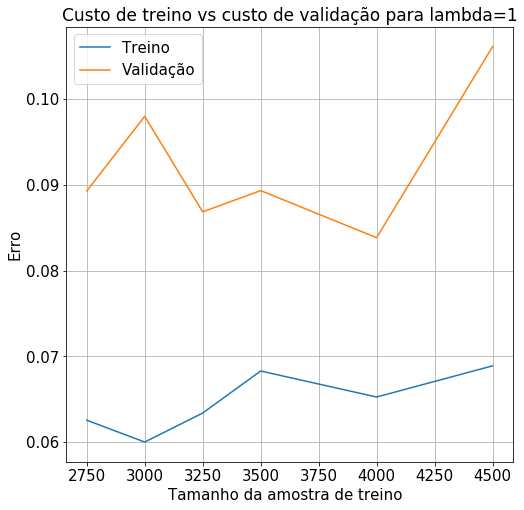

In [20]:
size_train = len(X)*percentage_train
fig = plt.figure(figsize=(8,8))
plt.plot([len(X)*i for i in percentage_train], J_train, label = 'Treino')
plt.plot([len(X)*i for i in percentage_train], J_aval, label = 'Validação')
plt.ylabel('Erro',size=15)  
plt.xlabel("Tamanho da amostra de treino  ",size=15)
plt.legend()
# plt.tick_params(left=False,  labelleft=False)
plt.title('Custo de treino vs custo de validação para lambda=%i'%Lambda,size=17)
plt.xticks(size=15)
plt.legend(fontsize=15)
plt.yticks(size=15)
plt.grid()
plt.show()

## The best $\lambda$

In [21]:
def listLambdas(X, y, percentage_train, input_layer_size, hidden_layer_size, num_labels, Lambdas, n_iter=400,alpha=0.8 ):
    
    J_aval = []
    X_train, X_aval, X_test, y_train, y_aval, y_test = sample(X,y, percentage_train, 1-percentage_train, 0) 
    theta_f = initial_theta_flatten
    
    for i in range(len(Lambdas)):
        theta, J_history = gradientDescent(X_train,y_train, theta_f, alpha ,n_iter, Lambdas[i],input_layer_size, hidden_layer_size, num_labels)
        theta_f = flattenTheta(theta,input_layer_size,hidden_layer_size,num_labels)
        Ja = Error(X_aval, y_aval, theta_f,input_layer_size,hidden_layer_size,num_labels)
        J_aval.append(Ja)
    
    lambda_min = np.argmin(J_aval)
    
    return J_aval, Lambdas[lambda_min]

In [24]:
Lambdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_per = 0.6

J_aval_lambda , opt_lambda = listLambdas(X, y, training_per , input_layer_size, hidden_layer_size, num_labels, Lambdas, 400, 0.8 )

print('The ideal lambda is ',opt_lambda)

The ideal lambda is  1


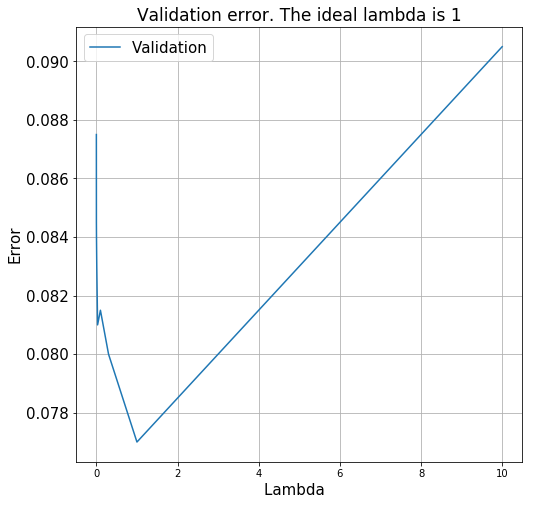

In [27]:
fig = plt.figure(figsize=(8,8))
plt.plot(Lambdas, J_aval_lambda, label = 'Validation')
plt.ylabel('Error',size=15)  
plt.xlabel("Lambda  ",size=15)
plt.legend()
plt.title('Validation error. The ideal lambda is %i'%opt_lambda ,size=17)
plt.legend(fontsize=15)
plt.yticks(size=15)
plt.grid()
plt.show()

### Calculate errors according to ideal lambda and best theta

In [41]:
# Gradient Descent 

n_iter = 500
alpha = 0.8
Lambda = opt_lambda

theta, J_history = gradientDescent(X_train,y_train, initial_theta_flatten, alpha ,n_iter, Lambda,input_layer_size, hidden_layer_size, num_labels)


## Errors

In [42]:
theta_f = flattenTheta(theta,input_layer_size,hidden_layer_size,num_labels)
pred = Error(X_train,y_train,theta_f,input_layer_size,hidden_layer_size,num_labels)
pred2 = Error(X_aval, y_aval, theta_f,input_layer_size,hidden_layer_size,num_labels)
pred3 = Error(X_test, y_test, theta_f,input_layer_size,hidden_layer_size,num_labels)


print('Training error:',pred, 'Validation error', pred2, 'Test error', pred3 )

Training error: 0.05166666666666675 Validation error 0.08899999999999997 Test error 0.07799999999999996
